In [1]:
import os
import numpy as np
from uncertainty_motion_prediction.dataloader import Dataloader

dataset=Dataloader();
traj_dataset = dataset.load(0)

# Get trajectories from the dataset

## As a list of Pandas dataframes

In [2]:
trajlets = traj_dataset.get_trajlets(length=4.8)
len(trajlets)

768

In [3]:
trajlets[0]

,frame_id,agent_id,pos_x,pos_y,vel_x,vel_y,scene_id,label,timestamp
5,804,2,13.017548,5.782591,-2.324444,-0.076606,0,pedestrian,53.6
7,810,2,12.087770,5.751949,-1.589052,-0.065971,0,pedestrian,54.0
9,816,2,11.746306,5.729815,-1.140766,0.105373,0,pedestrian,54.4
10,822,2,11.175158,5.836247,-1.640021,0.179235,0,pedestrian,54.8
11,828,2,10.434290,5.873203,-1.406129,0.419050,0,pedestrian,55.2
13,834,2,10.050254,6.171487,-1.078742,0.455190,0,pedestrian,55.6
15,840,2,9.571296,6.237355,-1.207725,0.115437,0,pedestrian,56.0
19,846,2,9.084074,6.263836,-1.273181,0.170841,0,pedestrian,56.4
24,852,2,8.552751,6.374027,-1.232733,0.271502,0,pedestrian,56.8
29,858,2,8.097887,6.481037,-1.146730,0.217892,0,pedestrian,57.2


## As numpy array

In [4]:
trajlets = traj_dataset.get_trajlets(length=4.8, to_numpy=True)
trajlets[0, :, :]

array([[13.017548  ,  5.7825914 , -2.3244442 , -0.07660594, 53.6       ],
       [12.08777   ,  5.751949  , -1.5890517 , -0.06597106, 54.        ],
       [11.746306  ,  5.7298146 , -1.1407656 ,  0.10537256, 54.4       ],
       [11.175158  ,  5.8362471 , -1.6400209 ,  0.17923528, 54.8       ],
       [10.43429   ,  5.8732028 , -1.4061292 ,  0.41904965, 55.2       ],
       [10.050254  ,  6.1714868 , -1.0787423 ,  0.45518986, 55.6       ],
       [ 9.5712958 ,  6.2373547 , -1.207725  ,  0.11543663, 56.        ],
       [ 9.0840742 ,  6.2638361 , -1.2731811 ,  0.17084078, 56.4       ],
       [ 8.5527509 ,  6.3740273 , -1.2327335 ,  0.2715015 , 56.8       ],
       [ 8.0978874 ,  6.4810373 , -1.1467297 ,  0.21789191, 57.2       ],
       [ 7.6353672 ,  6.5483408 , -1.1634956 ,  0.16930578, 57.6       ],
       [ 7.1670909 ,  6.616482  , -1.1264929 ,  0.11639996, 58.        ]])

# Kalman filter predictor using Constant Velocity model

Instantiate the Kalman filter using the Constant Velocity model, and perform some sanity checks.

In [5]:
from uncertainty_motion_prediction.evaluators import DistanceErrorEvaluator
from uncertainty_motion_prediction.predictor import ConstantVelocityKFPredictor

In [12]:
Q = np.eye(4) * 0.05
R = np.eye(4) * 0.05
pred = ConstantVelocityKFPredictor(N_future=4, dt=0.4, Q=Q, R=R)
test_traj1 = [[1, 1, 1, 0],
              [1.4, 1, 1, 0],
              [1.8, 1, 1, 0]]
test_traj2 = [[1.1, 1, 0, 1],
              [0.9, 1.4, 0, 1],
              [1.2, 1.8, 0, 1]] # inject some noise into the x-position
predicted_traj = pred.predict_batch(np.array([test_traj1, test_traj2]))
print(predicted_traj[:, :, 0:2])

[[[2.2        1.        ]
  [2.6        1.        ]
  [3.         1.        ]
  [3.4        1.        ]]

 [[1.10948978 2.2       ]
  [1.11415701 2.6       ]
  [1.11882424 3.        ]
  [1.12349148 3.4       ]]]


In [13]:
traj = trajlets[0, :, :]
point_est = pred.predict(traj[0:8, :])
samples = pred.sample(traj[0:8, :], count=1000)
print(point_est)

[[8.57742915 6.36207595]
 [8.07827963 6.43785919]
 [7.5791301  6.51364243]
 [7.07998057 6.58942567]]


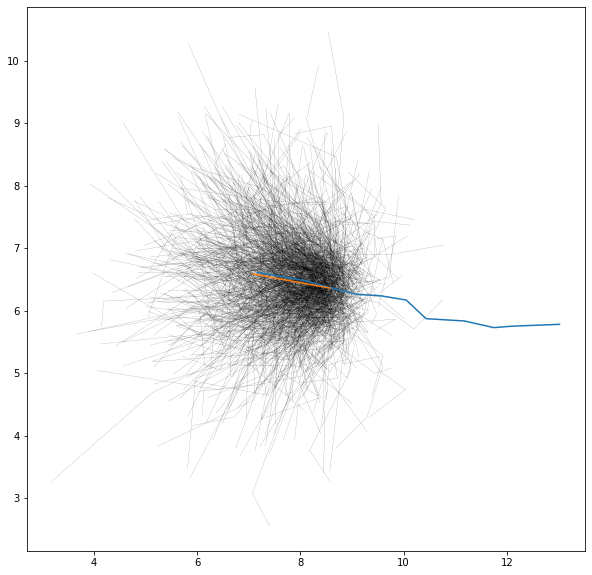

In [18]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(10, 10))

for s in samples:
    axs.plot(s[:, 0], s[:, 1], 'k-', linewidth=0.1)
axs.plot(traj[:, 0], traj[:, 1])
axs.plot(point_est[:, 0], point_est[:, 1])

# Evaluate ADE and FDE

Constant velocity predictor requires no training, hence there is no need to split the trajectories into train and validation sets.

In [15]:
pred = ConstantVelocityKFPredictor(N_future=4, dt=0.4)
evaluator = DistanceErrorEvaluator(N_future=4)
evaluator.evaluate(pred, trajlets)

{'fde': array([0.09274807, 0.35630421, 0.64790513, 0.68279455, 0.07532782,
        0.53444239, 0.44645236, 0.08940384, 0.12273124, 0.12650735,
        0.08716175, 0.05480205, 0.21983141, 0.11074096, 0.13355866,
        0.10044705, 0.49526427, 0.22898363, 0.41495568, 0.17064057,
        0.0448783 , 0.17198834, 0.05982476, 0.02557336, 0.09348895,
        0.12364331, 0.08888733, 0.31247567, 0.16637417, 0.24438923,
        0.11349136, 0.15294943, 0.09503882, 0.1641458 , 0.0190266 ,
        0.24188307, 0.66325402, 0.16149535, 0.26504422, 0.10588922,
        0.09604507, 0.15063676, 0.15247499, 0.3600173 , 0.23631627,
        0.05508881, 0.19889615, 0.35855152, 0.07096078, 0.23865006,
        0.19003499, 0.19463694, 0.01062378, 0.54905537, 0.10435245,
        0.26958713, 0.12359028, 0.43283739, 0.02623871, 0.07247337,
        0.67257975, 0.19769791, 0.29213298, 0.39217502, 0.20005641,
        0.01782867, 0.43865187, 0.23168527, 0.06795556, 0.14392939,
        0.36029734, 0.27144024, 0.0905573